# Chapter 8: Resampling and simulation

In [1]:
library(tidyverse)
library(ggplot2)
library(cowplot)
library(knitr)
theme_set(theme_minimal(base_size = 14))

set.seed(123456) # set random seed to exactly replicate results

# load the NHANES data library
library(NHANES)

# drop duplicated IDs within the NHANES dataset
NHANES <- NHANES %>%
  dplyr::distinct(ID,.keep_all=TRUE)

NHANES_adult <- NHANES %>%
  drop_na(Height) %>%
  subset(Age>=18)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.1     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


## Figure 8.1

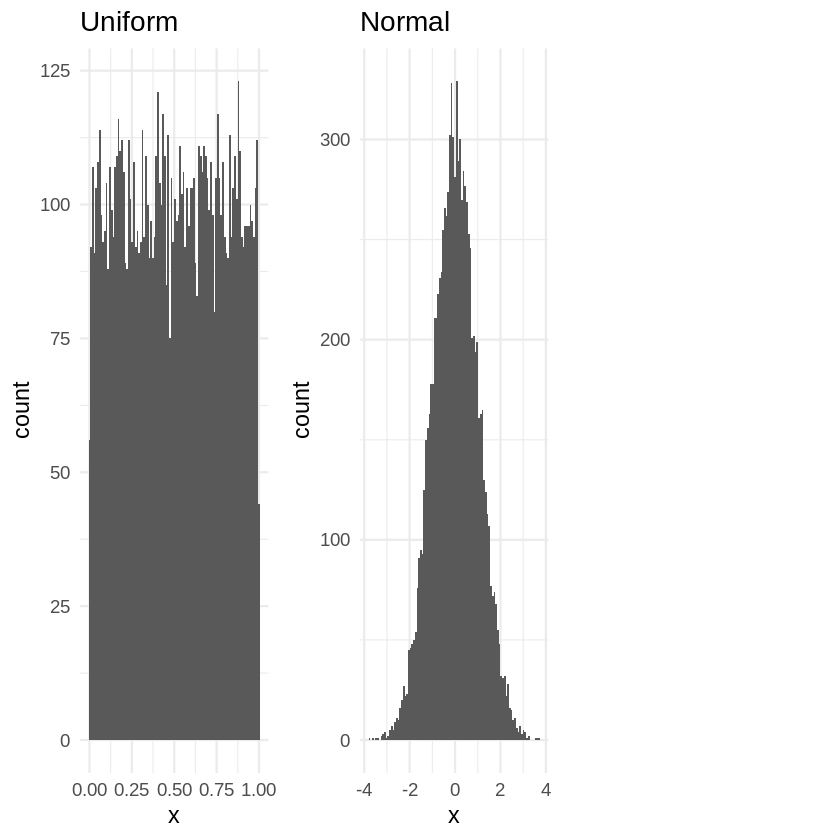

In [2]:
p1 <-
  tibble(
    x = runif(10000)
  ) %>%
  ggplot((aes(x))) +
  geom_histogram(bins = 100) +
  labs(title = "Uniform")

p2 <-
  tibble(
    x = rnorm(10000)
  ) %>%
  ggplot(aes(x)) +
  geom_histogram(bins = 100) +
  labs(title = "Normal")

plot_grid(p1, p2, ncol = 3)

## Figure 8.2

Warning message:
“Removed 6 rows containing missing values (`geom_bar()`).”


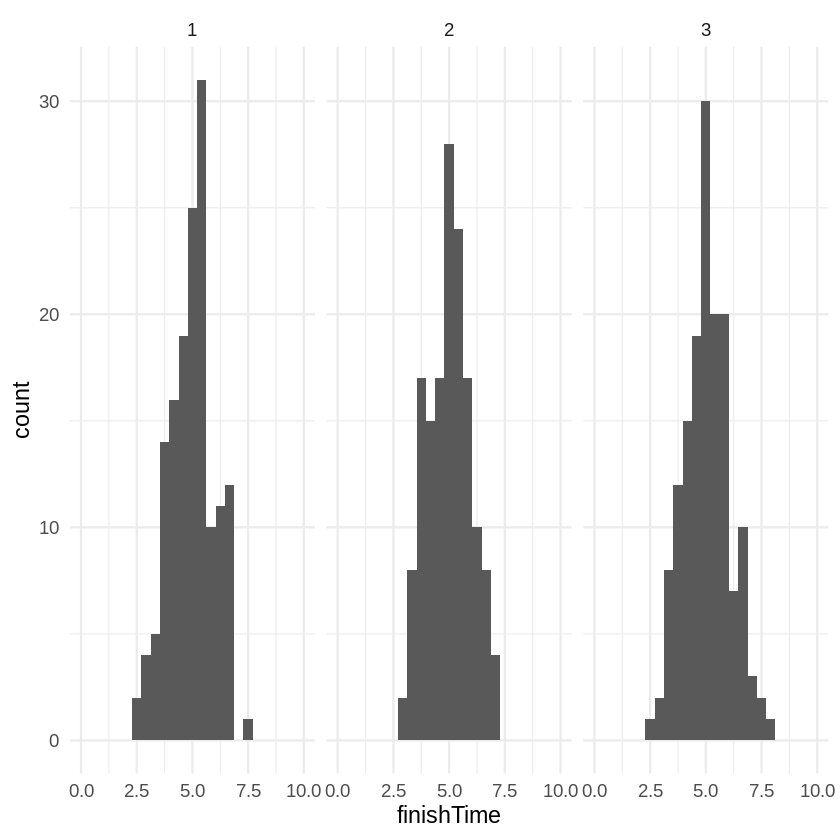

In [3]:
finishTimeDf <- tibble(finishTime=rnorm(3*150,mean=5,sd=1),
                        quiz=kronecker(c(1:3),rep(1,150)))

ggplot(finishTimeDf,aes(finishTime)) +
  geom_histogram(bins=25) +
  facet_grid(. ~ quiz) +
   xlim(0,10)

## Figure 8.3

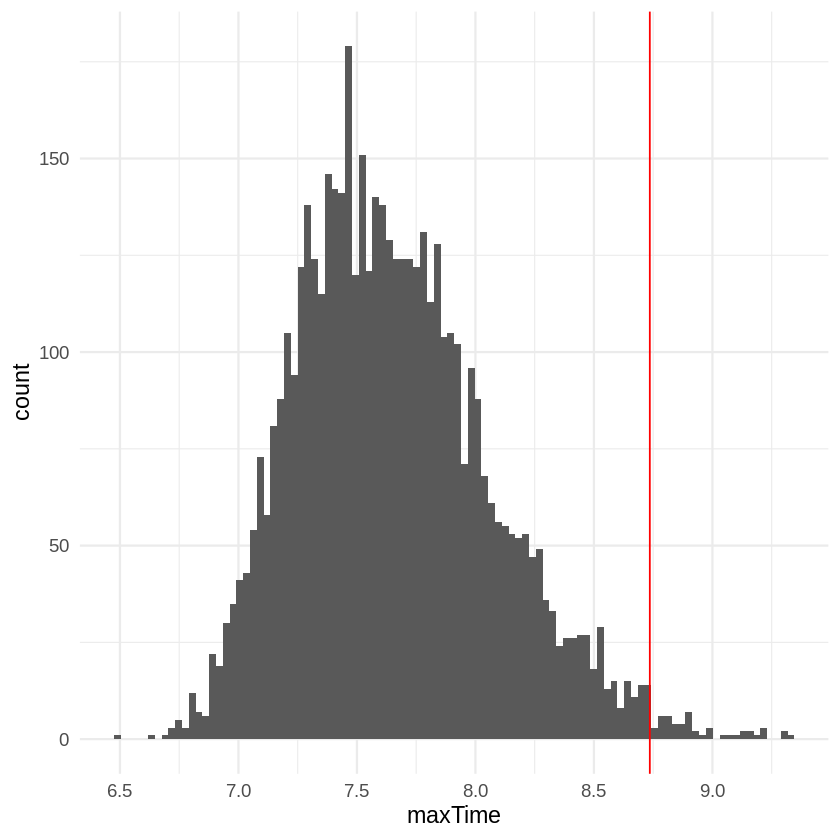

In [4]:
# sample maximum value 5000 times and compute 99th percentile
nRuns <- 5000
sampSize <- 150

sampleMax <- function(sampSize = 150) {
  samp <- rnorm(sampSize, mean = 5, sd = 1)
  return(max(samp))
}

maxTime <- replicate(nRuns, sampleMax())

cutoff <- quantile(maxTime, 0.99)

tibble(maxTime) %>%
  ggplot(aes(maxTime)) +
  geom_histogram(bins = 100) +
  geom_vline(xintercept = cutoff, color = "red")

## Figure 8.4

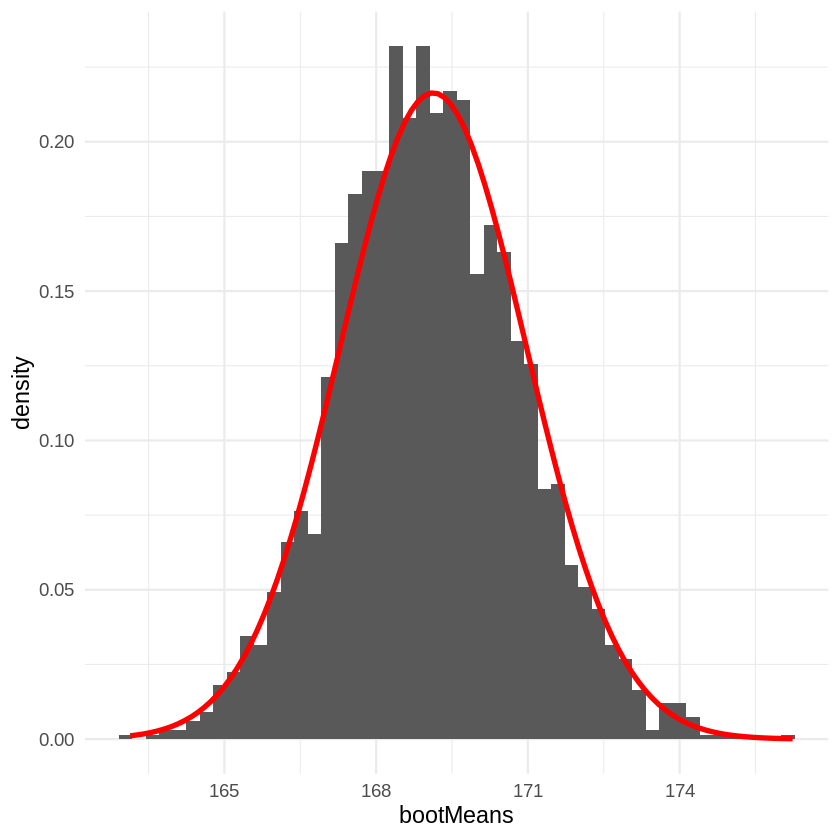

In [6]:
# perform the bootstrap to compute SEM and compare to parametric method

nRuns <- 2500
sampleSize <- 32

heightSample <-
  NHANES_adult %>%
  sample_n(sampleSize)

bootMeanHeight <- function(df) {
  bootSample <- sample_n(df, dim(df)[1], replace = TRUE)
  return(mean(bootSample$Height))
}

bootMeans <- replicate(nRuns, bootMeanHeight(heightSample))

SEM_standard <- sd(heightSample$Height) / sqrt(sampleSize)
SEM_bootstrap <- sd(bootMeans)

options(pillar.sigfig = 3)

tibble(bootMeans=bootMeans) %>%
  ggplot(aes(bootMeans)) +
    geom_histogram(aes(y=after_stat(density)),bins=50) +
  stat_function(fun = dnorm, n = 100,
                args = list(mean = mean(heightSample$Height),
                            sd = SEM_standard),
                linewidth=1.5,color='red'
                )